In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
from sklearn.ensemble import RandomForestClassifier

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# CODE PERSO
import mbr_kernel as mkn
from outils_classification_810 import compute_F2, compute_F2_custom, matrice_de_confusion_binaire
import outils_grid_search_810 as gs810
import outils_mlflow_810 as ml810


NOM_MODELE_BASE='RandomForest'

TEST_SIZE = 0.2
RANDOM_STATE = 42
GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'
TMP_FOLDER = GIT_FOLDER+'tmp/'

In [2]:
# ---------------------------------------------------------------- MAKE SCRORER
F2_score = make_scorer(compute_F2, greater_is_better=True)
F2custom_score = make_scorer(compute_F2_custom, greater_is_better=True)

In [3]:
def transform_X(X):
    """Applique les transformation qui precede l'estimator dans le Pipeline. Permet d'obtenir une version des donnees telle que l'estimator traitera"""
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    X_imp = imputer.fit_transform(X)
    X_sc = scaler.fit_transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X


def test_model(data, estimator, confusion=False, over_sampling=0.1, under_sampling=0.5, do_under=True) :
    """Permet de tester un model, sans enregistrer les resultats dans MLFlow"""
    print("PREPARING MODEL")
    X = data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    y = data['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
    print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler()
    over = SMOTE(sampling_strategy=over_sampling, random_state=RANDOM_STATE)
    if do_under :
        under = RandomUnderSampler(sampling_strategy=under_sampling, random_state=RANDOM_STATE)
    estimator = estimator

    if do_under :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("under", under),
            ("estimator", estimator)
        ])
    else :
        be = Pipeline([
            ("imputer", imputer),
            ("scaler", scaler),
            ("over", over),
            ("estimator", estimator)
        ])

    be.fit(X_train, y_train)

    print("TESTING MODEL")
    y_pred = be.predict(X_test)
    y_train_pred = be.predict(X_train)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = compute_F2(y_true=y_train, y_pred=y_train_pred)
    train_F2c_score = compute_F2_custom(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print("TRAIN F2 score", train_F2_score)
    print("TRAIN F2Custom score", train_F2c_score)
    print("TRAIN AUC", train_auc_score)
    print("TRAIN Recall", train_rappel)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = compute_F2(y_true=y_test, y_pred=y_pred)
    test_F2c_score = compute_F2_custom(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("TEST F2 score", test_F2_score)
    print("TEST F2Custom score", test_F2c_score)
    print("TEST AUC", test_auc_score)
    print("TEST Recall", test_rappel)

    if confusion :
        matrice_de_confusion_binaire(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=TMP_FOLDER, nomfichier="model_Test_cm.png")
    return {'model' : be, 'test_F2' : test_F2_score, 'test_aux' : test_auc_score, 'test_rappel' : test_rappel}


# PREPROCESS DATA

In [4]:
df_train = pd.read_csv('./input_data/application_train.csv')
df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 14)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 7s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 23s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 5s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 15s
CC dataframe shape:  (103558, 6)
CC processing - done in 6s
X_train : (175724, 48) // X_test : (43932, 48)
y_train : (175724,) // y_test : (43932,)


# GRIDSEARCH

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier(class_weight='balanced')

pipeline = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

params = {
    'estimator__max_depth' : [10, 50, 100],
    'estimator__min_samples_split' : [20, 100, 500],
    'estimator__n_estimators' : [100, 300, 500]
}

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=F2_score,
    return_train_score=True,
    verbose=2,
    n_jobs=-1
)

model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [10, 50, 100],
                         'estimator__min_samples_split': [20, 100, 500],
                         'estimator__n_estimators': [100, 300, 500]},
             return_train_score=True, scoring=make_scorer(compute_F2),
             verbose=2)

N.B : Lorsqu'on a realise un feature engineering assez pousse, il est rare que la regression logistique ait besoin de plus de 100 iterations. Cet hyperparametre n'apporte alors aucun interet a la GridSearch.

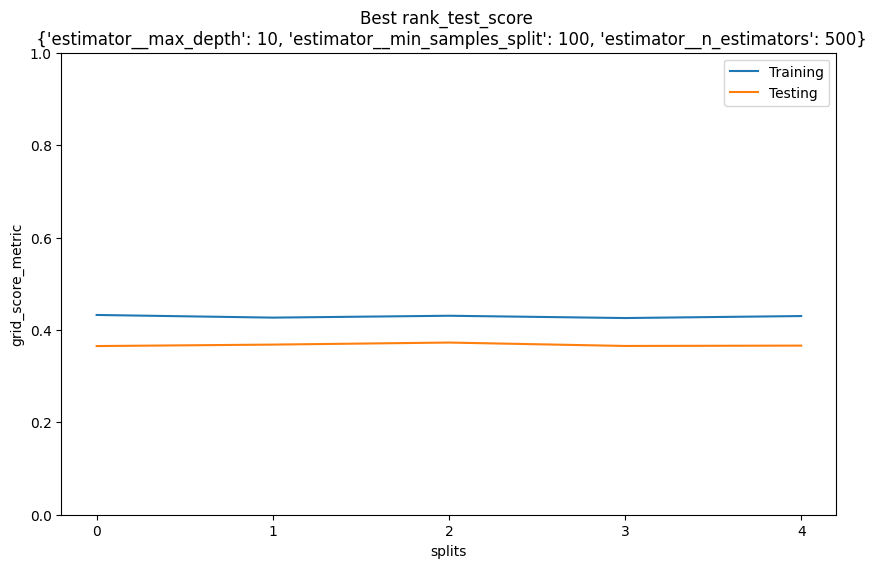

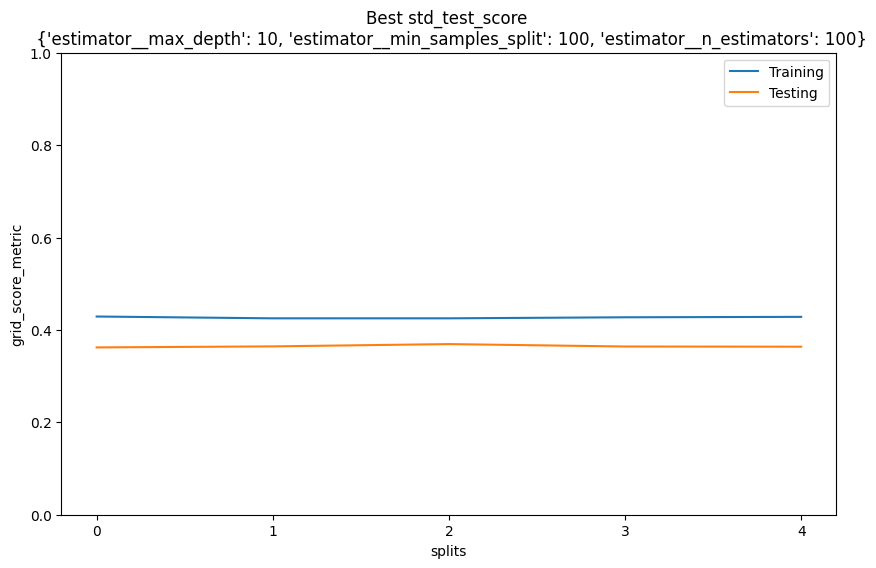

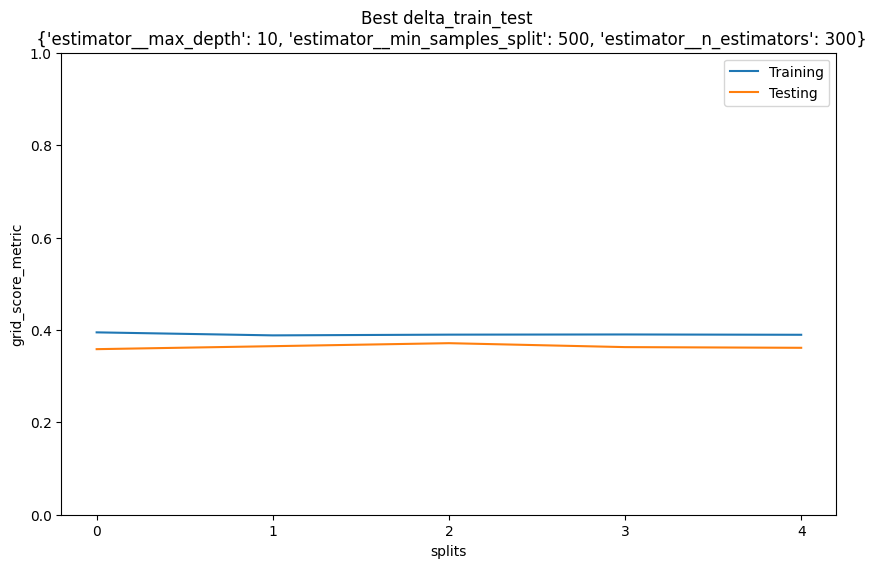

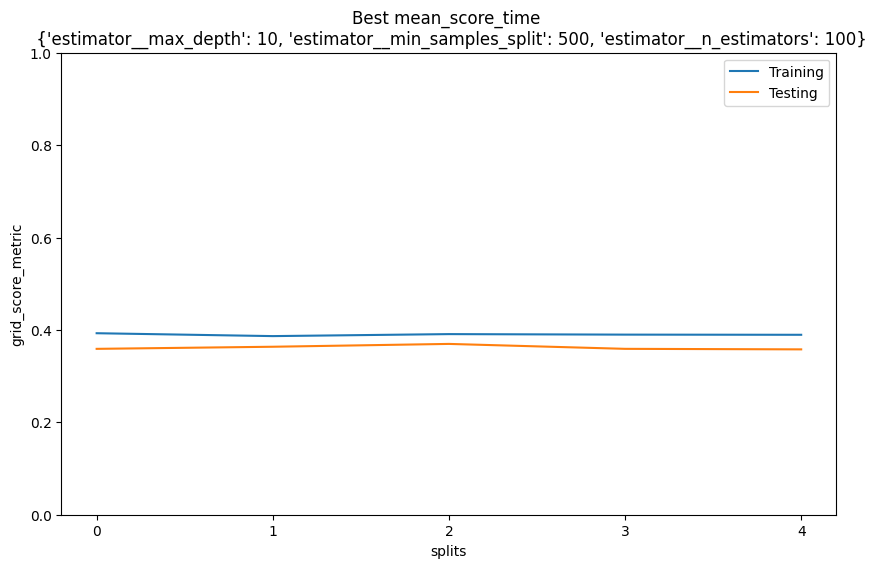

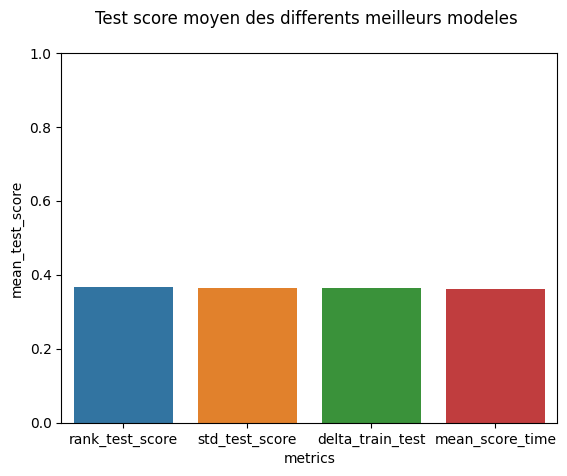

In [6]:
grid_results = gs810.grid_resultification(grid=model)
df_to_plot, df_models = gs810.get_split_scores_for_model(res_grid=grid_results, nb_cv=5)
list_img, path_to_models_csv =gs810.plot_split_scores(df_to_plot, df_models, save=True, path=TMP_FOLDER)

In [8]:
grid_results[['params','mean_score_time', 'mean_test_score']]

,params,mean_score_time,mean_test_score
0,"{'estimator__class_weight': 'balanced', 'estim...",0.660572,0.407042
1,"{'estimator__class_weight': 'balanced', 'estim...",3.109901,0.406213
2,"{'estimator__class_weight': 'balanced', 'estim...",6.418977,0.406496
3,"{'estimator__class_weight': 'balanced', 'estim...",0.669521,0.405193
4,"{'estimator__class_weight': 'balanced', 'estim...",3.179311,0.407907
5,"{'estimator__class_weight': 'balanced', 'estim...",6.177276,0.407922
6,"{'estimator__class_weight': 'balanced', 'estim...",0.512756,0.400233
7,"{'estimator__class_weight': 'balanced', 'estim...",2.344601,0.400954
8,"{'estimator__class_weight': 'balanced', 'estim...",4.541411,0.402569
9,"{'estimator__class_weight': 'balanced', 'estim...",1.014930,0.374880


Pour ameliorer le __temps d'execution :__
- gros min_sample_split ET/OU petit max_depth : Reduit necessairement la profondeur des arbres, et peut donc meme etre redondant avec max_depth
- peu de n_estimators : Passer de 100 a 500 double le temps d'execution.

Un __test score__ eleve passe necessairement par  :
- un class_weight balanced

Reduire au maximum __l'overfitting__ passe par :
- un gros min_sample_split puisqu'il assure qu'on n'analyse jamais des cas trop particuliers

Choix :
Le deuxieme meilleur min-test score represente le meilleur choix, dans le sens ou il offre presque le meme mean-test-score que le meilleur model, mais est 10 fois plus rapide : {'estimator__class_weight': 'balanced', 'estim...

In [7]:
grid_results.iloc[0, :]

mean_fit_time                                                                 15.171246
std_fit_time                                                                    0.19384
mean_score_time                                                                0.641897
std_score_time                                                                 0.007356
param_estimator__max_depth                                                           10
param_estimator__min_samples_split                                                   20
param_estimator__n_estimators                                                       100
params                                {'estimator__max_depth': 10, 'estimator__min_s...
split0_test_score                                                              0.356475
split1_test_score                                                              0.361493
split2_test_score                                                               0.37114
split3_test_score               

In [8]:
ml810.save_grid_results(list_of_image=list_img,
                        grid_estimator=NOM_MODELE_BASE,
                        ini_params="",
                        path_to_csv=path_to_models_csv)

# TRAIN/TEST BEST MODEL
## 1. HyperParams custom en fonction de ma comprehension de l'algorithme

### Avec les parametres definis ci-dessus

PREPARING MODEL
X_train : (175724, 48) // X_test : (43932, 48)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.44705825756482415
TRAIN F2Custom score 0.5373664245732526
TRAIN AUC 0.7256183469801022
TRAIN Recall 0.7121618514828723
TEST F2 score 0.3606764841233318
TEST F2Custom score 0.42977585852354516
TEST AUC 0.6512780033157065
TEST Recall 0.5766400980993256


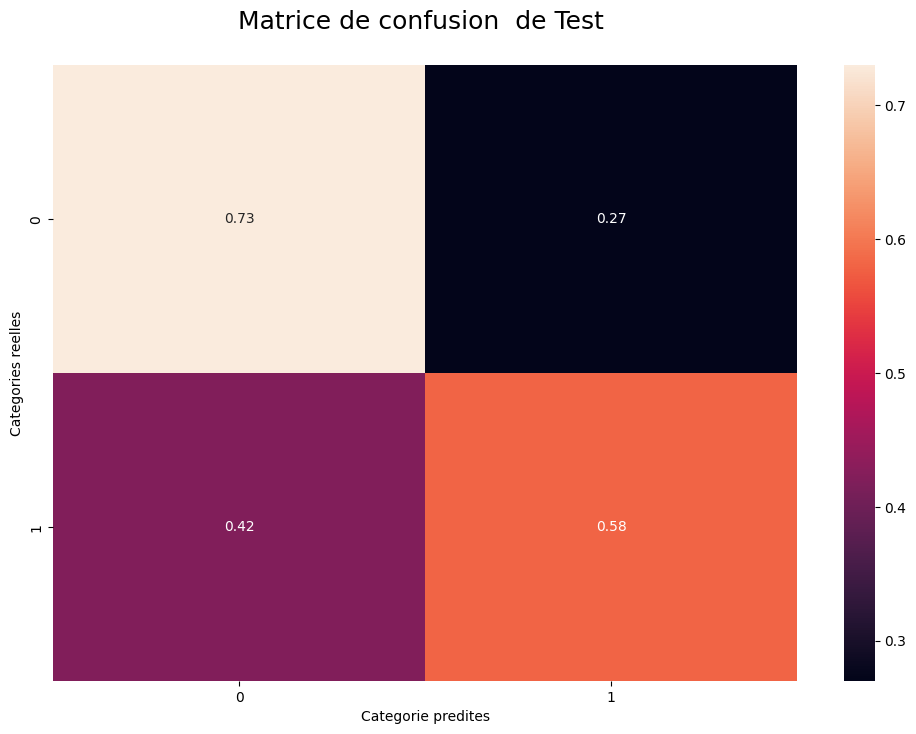

In [9]:
dict_results = test_model(df, RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=20, n_estimators=100),
                            confusion=True, over_sampling=0.1, under_sampling=0.5, do_under=True)

### Avec des hyperparametres precedemment identifies

PREPARING MODEL
X_train : (175724, 48) // X_test : (43932, 48)
y_train : (175724,) // y_test : (43932,)
TESTING MODEL
TRAIN F2 score 0.3815407299503477
TRAIN F2Custom score 0.47129236474550984
TRAIN AUC 0.6699814522092569
TRAIN Recall 0.6583646256418116
TEST F2 score 0.35711756373937675
TEST F2Custom score 0.44044109618954036
TEST AUC 0.6471917274071322
TEST Recall 0.6183323114653587


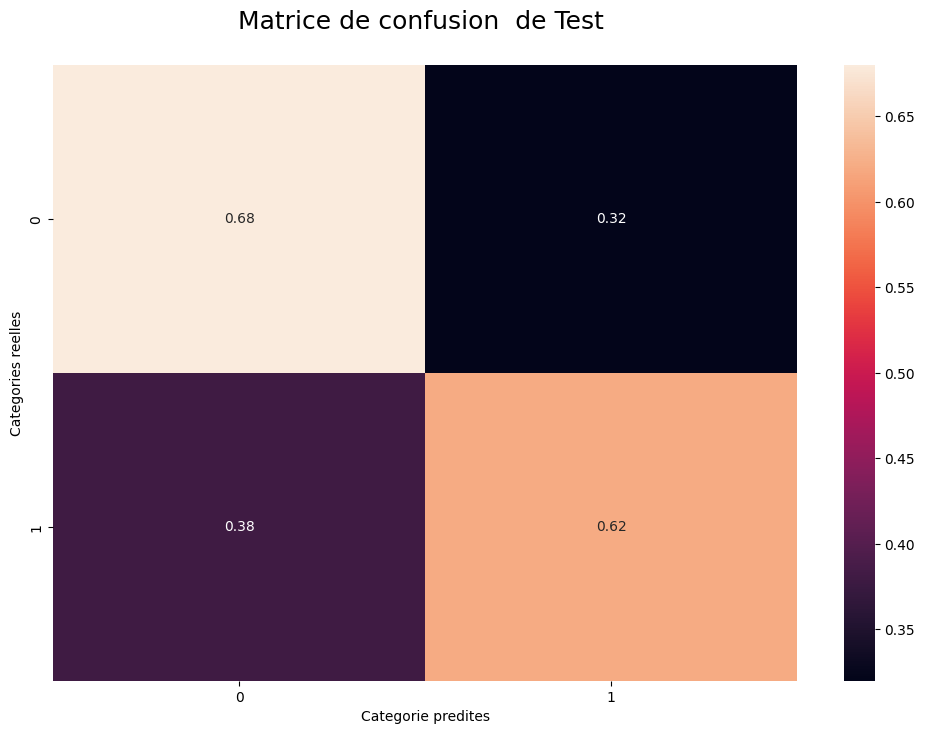

In [10]:
dict_results = test_model(df, RandomForestClassifier(class_weight='balanced', min_samples_split=800, n_estimators=500),
                            confusion=True, over_sampling=0.1, under_sampling=0.5, do_under=True)

## 2. Best Model de la GridSearch

In [11]:
estimator = RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_split=20, n_estimators=100)

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=20))])

/home/maximorose/anaconda3/envs/oc_ds_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


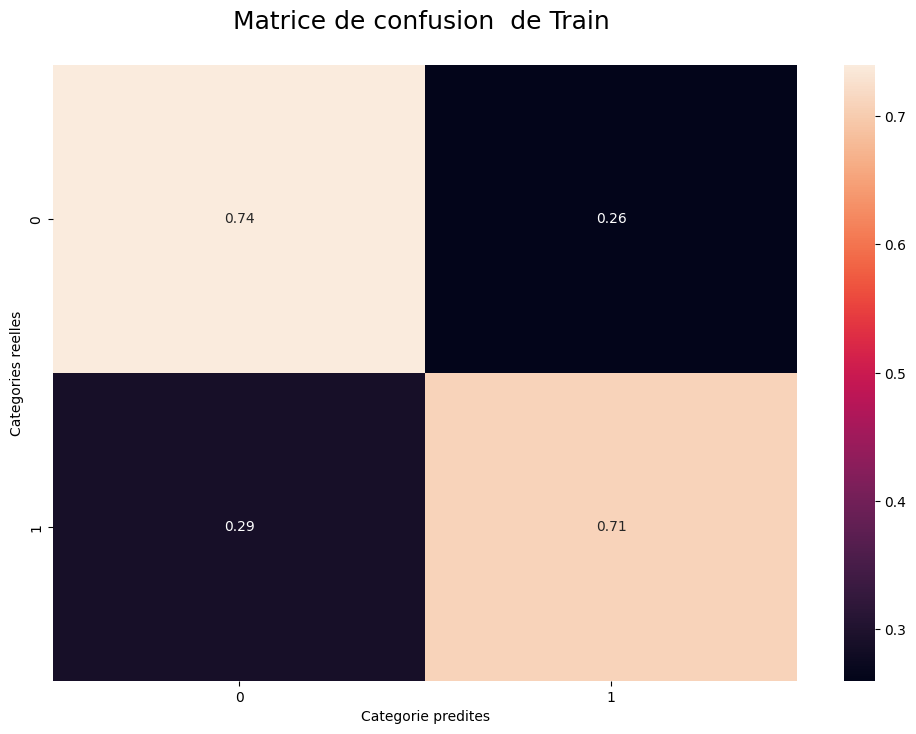

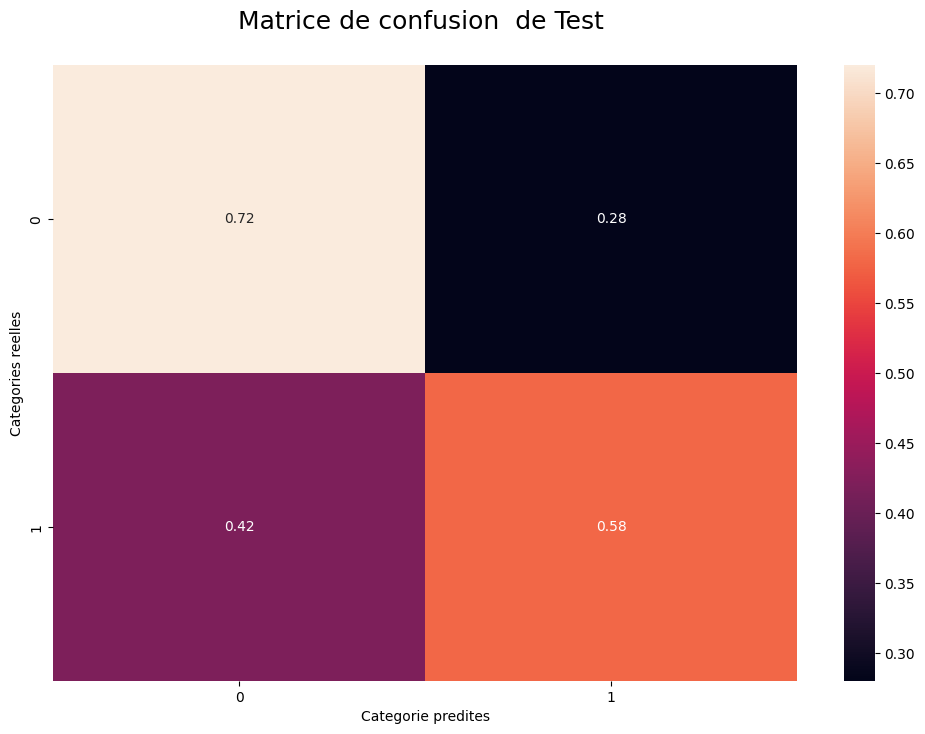

In [12]:
ml810.classification_binaire_save_results(xglob=X, model=model,
                                          xtrain=X_train, ytrain=y_train,
                                          xtest=X_test, ytest=y_test,
                                          nom_model=NOM_MODELE_BASE,
                                          estimator=NOM_MODELE_BASE,
                                          tmp_folder=TMP_FOLDER)